In [1]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import arviz as az
from sklearn import preprocessing

from scipy.stats import stats

%matplotlib inline

In [2]:
data = pd.read_csv('../../data/foxes.csv', sep=';')

In [3]:
data.head(5)

,group,avgfood,groupsize,area,weight
0,1,0.37,2,1.09,5.02
1,1,0.37,2,1.09,2.84
2,2,0.53,2,2.05,5.33
3,2,0.53,2,2.05,6.07
4,3,0.49,2,2.12,5.85


##### Question 1

There is no backdoor path from area to weight. Hence, we have only one predictor variable (i. e. area)let's standardize this dataset (I'msing using Scikit-Learn) 

Let's standardize this dataset (I'msing using Scikit-Learn) 

In [4]:
def standardize(data):
    return preprocessing.scale(data)

data[['avgfood','groupsize','area','weight']] = \
    preprocessing.scale(data[['avgfood','groupsize','area','weight']])

In [5]:
data.head(5)

,group,avgfood,groupsize,area,weight
0,1,-1.933180,-1.530701,-2.249313,0.415931
1,1,-1.933180,-1.530701,-2.249313,-1.433238
2,2,-1.122886,-1.530701,-1.210738,0.678887
3,2,-1.122886,-1.530701,-1.210738,1.306586
4,3,-1.325459,-1.530701,-1.135008,1.119973


In [6]:
# Let's build the model for the first queston
with pm.Model() as q_1_model:
    # our data
    weight = pm.Data('weight', data['weight'].values)
    area = pm.Data('area', data['area'].values)
    
    # priors
    alpha = pm.Normal('alpha', mu=0.0, sd=0.2)
    beta = pm.Normal('beta', mu=0.0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    # model
    mu = alpha + beta*area
    weight_pred = pm.Normal('weight_pred', mu=mu, sd=sigma, observed=weight)
    # samples 
    prior = pm.sample_prior_predictive(samples=50)
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [00:15<00:00, 127.39it/s]


In [7]:
pm.summary(posterior, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-0.002,0.089,-0.164,0.162,0.002,0.002,2377.0,894.0,2364.0,1275.0,1.01
beta,0.021,0.096,-0.165,0.187,0.002,0.002,2390.0,954.0,2421.0,1177.0,1.00
sigma,1.014,0.069,0.877,1.135,0.001,0.001,2407.0,2407.0,2485.0,1405.0,1.01


The **`beta`** coefficient is relatively low. So it seems like the area has no cocausal influence on the weight. 

In [8]:
df = pd.DataFrame()
df = df.assign(alpha = pd.Series(prior['alpha']),
               sigma = pd.Series(prior['sigma']),
               beta = pd.Series(prior['beta']))
len(df)

50

In [9]:

priors = pd.DataFrame()

for i in range(df.shape[0]):
    priors['prior_'+str(i)] = df.loc[i,'alpha'] + df.loc[i,'beta'] * data['area']

In [10]:
aux = pd.concat([data.area, priors], axis=1)
aux_plot = aux.melt(id_vars=['area'],
                  value_vars=list(aux.columns)[1:],
                  var_name='prior',
                  value_name='weight')

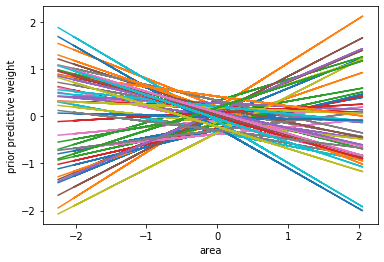

In [11]:
for i in range(50):
    plt.plot(aux['area'].values, aux['prior_'+str(i)].values)
plt.xlabel('area')
plt.ylabel('prior predictive weight')
plt.show()

##### Question 2

Now we need to investigate the causal effect of adding teritory, and would this make foxes heavier?

Now we don't have backdoor paths. But there is an indirect path in the graph from avefood to weight (**`avgfood` -> `groupsize` -> `weight`**). If we close this path we will not get the total causal influence of food. 

So we have only one predictor variable (i.e. **`avgfood`**)

In [12]:
# Let's build the model for the first queston
with pm.Model() as q_1_model:
    # our data
    weight = pm.Data('weight', data['weight'].values)
    avgfood = pm.Data('avgfood', data['avgfood'].values)
    
    # priors
    alpha = pm.Normal('alpha', mu=0.0, sd=0.2)
    beta = pm.Normal('beta', mu=0.0, sd=0.5)
    sigma = pm.Exponential('sigma', lam=1.0)
    
    # model
    mu = alpha + beta*avgfood
    weight_pred = pm.Normal('weight_pred', mu=mu, sd=sigma, observed=weight)
    # samples 
    prior = pm.sample_prior_predictive(samples=50)
    posterior = pm.sample()
    posterior_pred = pm.sample_posterior_predictive(posterior)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]
100%|██████████| 2000/2000 [00:16<00:00, 118.78it/s]


In [13]:
pm.summary(posterior, var_names=['alpha', 'beta', 'sigma'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.002,0.085,-0.160,0.162,0.002,0.002,2848.0,1184.0,2841.0,1820.0,1.00
beta,-0.024,0.091,-0.198,0.140,0.002,0.002,2339.0,1060.0,2309.0,1528.0,1.01
sigma,1.014,0.064,0.901,1.134,0.001,0.001,2368.0,2332.0,2395.0,1525.0,1.00


##### Question 3